# Shifted pictures

In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

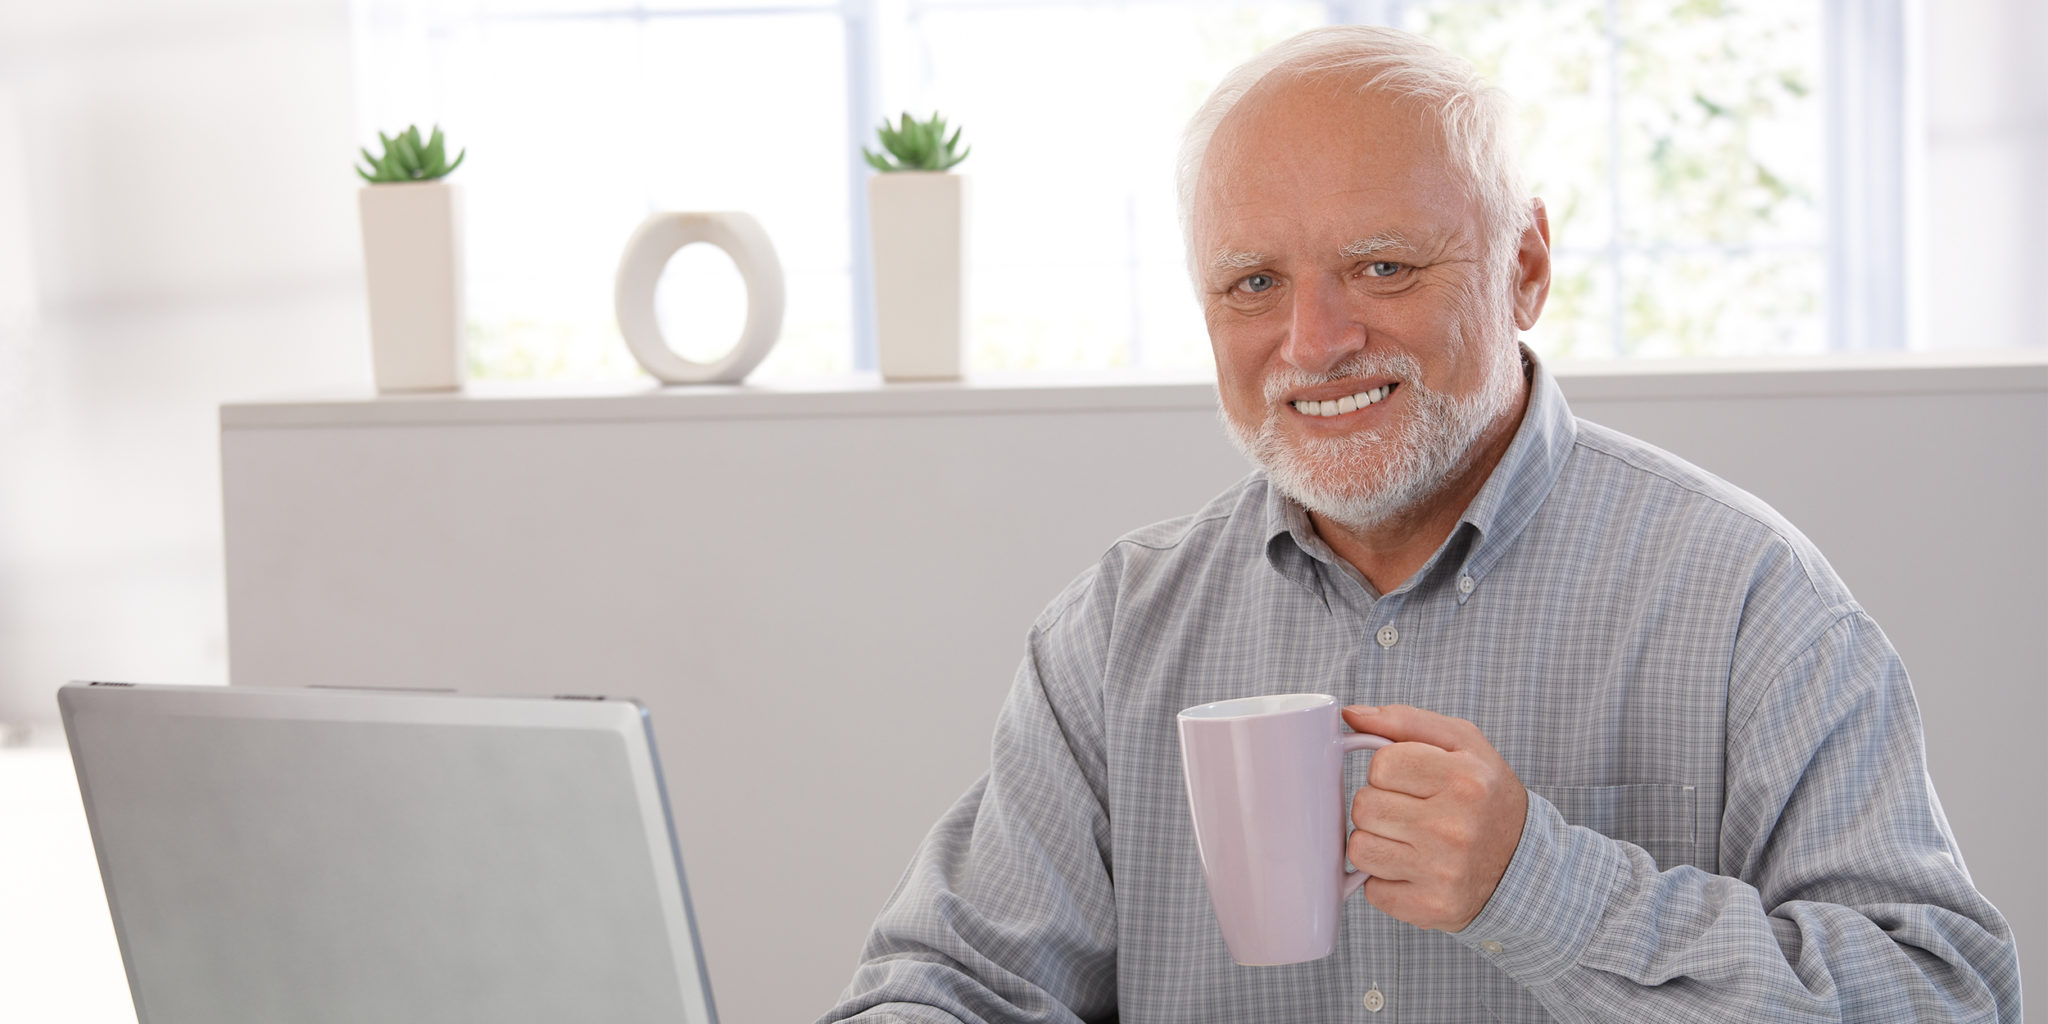

In [2]:
Image.open('images/task_08/im.jpg')

In [3]:
%%writefile task_08_shift_im_mpi.py

import os
import numpy as np
import tracemalloc

from PIL import Image
from mpi4py import MPI

tracemalloc.start()

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

IS_ROOT = rank == 0
IS_SAVE = False

H = 1024
W = 2048
numDataPerRank = H // size

data = None

if IS_ROOT:
    data = np.array(Image.open('images/task_08/im.jpg'))
    numDataPerRank =  H - (numDataPerRank * (size - 1))

if IS_SAVE:
    os.makedirs('images/task_08/images', exist_ok=True)

received = np.empty((numDataPerRank, W, 3), dtype=np.uint8)
sendcounts = np.array(comm.gather(received.size, 0))

def roll(arr):
    res = np.empty_like(arr)
    w = arr.shape[1]
    for i in range(w):
        res[:, (i + 1) % w] = arr[:, i]
    return res
    
for i in range(W):
    comm.Scatterv((data, sendcounts), received, root=0)
    received_rolled = roll(received)
    comm.Gatherv(received_rolled, (data, sendcounts), root=0)
    if IS_ROOT and IS_SAVE:
        Image.fromarray(data).save(f'images/task_08/images/{i:0>5d}.jpg')


current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

peak = np.array(comm.gather(peak, 0))
if IS_ROOT:
    print(size)
    print(np.sum(peak / 1024 / 1024))

Writing task_08_shift_im_mpi.py


In [4]:
!mpirun -n 10 --allow-run-as-root --mca btl ^vader python3 task_08_shift_im_mpi.py
print('MPI done')

images = []
files = [f for f in os.listdir('images/task_08/images') if os.path.isfile(os.path.join('images/task_08/images', f))]
files.sort()
for f in files:
    images.append(Image.open('images/task_08/images/' + f).resize((256, 128)))

imageio.mimsave('images/task_08/shift.gif', images, fps=200)

!rm -r images/task_08/images

![Gif](images/task_08/shift.gif)

In [5]:
time_arr = []
processes = range(1, 12)
for i in processes:
    print(f'{i} process(es)\n\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_08_shift_im_mpi.py 1>>log.log
    time_arr.append(t.best)

1 process(es)
	14.5 s ± 28.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 process(es)
	8.72 s ± 53.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3 process(es)
	6.54 s ± 70.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 process(es)
	5.42 s ± 208 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
5 process(es)
	4.89 s ± 83.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6 process(es)
	4.72 s ± 87.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
7 process(es)
	4.58 s ± 28.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
8 process(es)
	4.52 s ± 24.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
9 process(es)
	4.51 s ± 126 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
10 process(es)
	4.45 s ± 49.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
11 process(es)
	4.44 s ± 30.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 0.98, 'SpeedUp vs Num of processes')

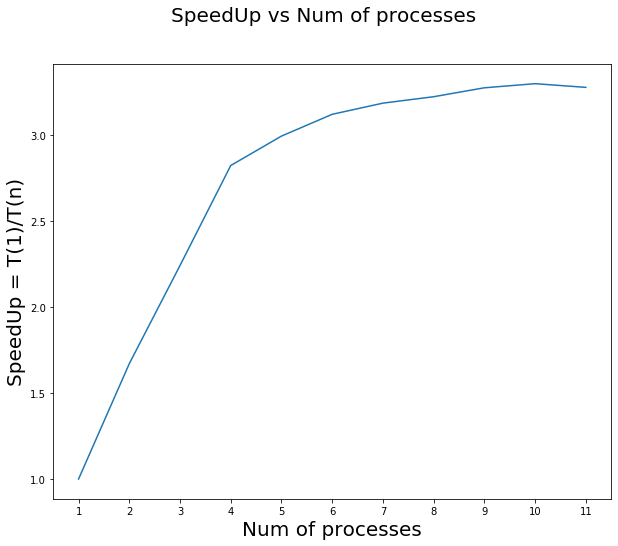

In [6]:
speedup = time_arr[0] / np.array(time_arr)

plt.figure(figsize=(10, 8))
plt.plot(processes, speedup)
plt.xticks(processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.suptitle('SpeedUp vs Num of processes', fontsize=20)

In [7]:
with open('log.log', 'r') as log:
    data = log.readlines()
data = np.array(data)
x = data[::2][::4].astype(int)
y = data[1::2][::4].astype(float)
!rm log.log

Text(0.5, 0.98, 'Memory vs Num of processes')

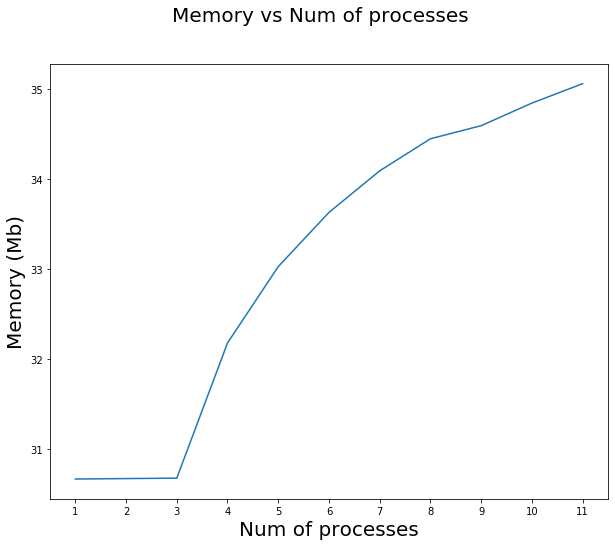

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(x, y)
plt.xticks(x)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('Memory (Mb)', fontsize=20)
plt.suptitle('Memory vs Num of processes', fontsize=20)